## Object detection
https://deepstackpython.readthedocs.io/en/latest/objectdetection.html

Run with:
```
sudo docker run -e VISION-DETECTION=True -v localstorage:/datastore -p 5000:5000 deepquestai/deepstack
```

In [1]:
import requests
import matplotlib.pyplot as plt 
from PIL import Image
%matplotlib inline

IP = "localhost"
PORT = "5000"

In [2]:
img_file = "test-image3.jpg"

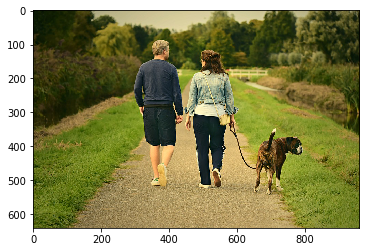

In [3]:
image = Image.open(img_file).convert("RGB")
plt.imshow(image);

In [4]:
image_data = open(img_file,"rb").read()
response = requests.post(f"http://{IP}:{PORT}/v1/vision/detection", files={"image":image_data})

In [5]:
response.status_code

200

In [6]:
# response.json()

In [7]:
predictions = response.json()['predictions']
predictions

[{'confidence': 99,
  'label': 'person',
  'y_min': 89,
  'x_min': 297,
  'y_max': 513,
  'x_max': 444},
 {'confidence': 99,
  'label': 'person',
  'y_min': 114,
  'x_min': 443,
  'y_max': 516,
  'x_max': 598},
 {'confidence': 99,
  'label': 'dog',
  'y_min': 354,
  'x_min': 640,
  'y_max': 544,
  'x_max': 810}]

In [14]:
len(predictions)

3

In [8]:
def get_object_classes(predictions):
    """
    Get a list of the unique object classes predicted.
    """
    classes = [pred['label'] for pred in predictions]
    return set(classes)

In [9]:
classes = get_object_classes(predictions)
classes

{'dog', 'person'}

In [10]:
def get_object_instances(predictions, target):
    """
    Return the number of instances of a target class.
    """
    targets_identified = [pred for pred in predictions if pred['label'] == target]
    return len(targets_identified)

In [15]:
predictions_json = [{'confidence': 99, 'label': 'person', 'y_min': 89, 'x_min': 297, 'y_max': 513, 'x_max': 444}, {'confidence': 99, 'label': 'person', 'y_min': 114, 'x_min': 443, 'y_max': 516, 'x_max': 598}, {'confidence': 99, 'label': 'dog', 'y_min': 354, 'x_min': 640, 'y_max': 544, 'x_max': 810}]

In [16]:
predictions_json

[{'confidence': 99,
  'label': 'person',
  'y_min': 89,
  'x_min': 297,
  'y_max': 513,
  'x_max': 444},
 {'confidence': 99,
  'label': 'person',
  'y_min': 114,
  'x_min': 443,
  'y_max': 516,
  'x_max': 598},
 {'confidence': 99,
  'label': 'dog',
  'y_min': 354,
  'x_min': 640,
  'y_max': 544,
  'x_max': 810}]

In [17]:
get_object_instances(predictions_json, target='person')

2

In [12]:
def get_objects_summary(predictions):
    """
    Get a summary of the objects detected.
    """
    classes = get_object_classes(predictions)
    return {class_cat : get_object_instances(predictions, target=class_cat) 
            for class_cat in classes}

In [13]:
get_objects_summary(predictions)

{'person': 2, 'dog': 1}